# Modules

In [1]:
pip install beautifulsoup4

     |████████████████████████████████| 115 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [78]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 999)
pd.options.mode.chained_assignment = None
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup
import multiprocessing as mp
import time
from tqdm import tqdm
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import json
from pprint import pprint
from nltk.util import ngrams
from nltk.corpus import stopwords
from wordcloud import WordCloud#, STOPWORDS 
import itertools
import collections

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/autoru-20210328/cars_extra_11_2021-04-01.csv
/kaggle/input/autoru-20210328/skoda-2021-03-28.csv
/kaggle/input/autoru-20210328/cars_extract.csv
/kaggle/input/autoru-20210328/test_extra_3_2021-03-31.csv
/kaggle/input/autoru-20210328/volvo-2021-03-28.csv
/kaggle/input/autoru-20210328/cars_extra_5_2021-03-31.csv
/kaggle/input/autoru-20210328/cars_extra_10_2021-04-01.csv
/kaggle/input/autoru-20210328/mercedes-2021-03-29.csv
/kaggle/input/autoru-20210328/cars_extra_8_2021-04-01.csv
/kaggle/input/autoru-20210328/volkswagen-2021-03-30.csv
/kaggle/input/autoru-20210328/bmw-2021-03-29.csv
/kaggle/input/autoru-20210328/cars_extra_9_2021-04-01.csv
/kaggle/input/autoru-20210328/cars_extra_1_2021-03-31.csv
/kaggle/input/autoru-20210328/cars_extra_12_2021-04-01.csv
/kaggle/input/autoru-20210328/toyota-2021-03-30.csv
/kaggle/input/autoru-20210328/test_extra_2_2021-03-31.csv
/kaggle/input/autoru-20210328/test_extra_1_2021-03-31.csv
/kaggle/input/autoru-20210328/test_extra_4_2021-03-31.csv

# EDA

In [3]:
test = pd.read_csv('/kaggle/input/sf-dst-car-price-prediction/test.csv')

In [4]:
# Следущий код за несколько часов загружает дополнительные поля порциями по 10 тыс. строк
def parse_extra(url):
    soup = BeautifulSoup(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content, 'lxml')
    try:
        script_init = json.loads(soup.find('script', {'id': 'initial-state'}).contents[0])
        reqion = script_init['card']['seller']['location']['region_info']['name']
        vehicle_info = script_init['card']['vehicle_info']
        return pd.DataFrame([(url, reqion, vehicle_info)], columns = ['url', 'reqion', 'vehicle_info'])
    except:
        print(url)
        return None

if False:
    for i in range(1,4):
        result = []
        interval = range((i-1)*10000, np.minimum(i*10000, len(test)))
        print(interval)
        for url in tqdm(test.iloc[interval]['car_url']):
            row = parse_extra(url)
            if row is not None:
                result.append(row)
        result = pd.concat(result).reset_index().drop(columns = ['index'])
        result.to_csv('test_extra_' + str(i) + '_' + datetime.today().strftime('%Y-%m-%d') + '.csv')

In [5]:
# Загружаем дополнительные поля из csv
test_extra = []
for dirname, _, filenames in os.walk('/kaggle/input/autoru-20210328'):
    for filename in filenames:
        if 'test_extra_' in filename:
            test_extra.append(pd.read_csv(os.path.join(dirname, filename)))
test_extra = pd.concat(test_extra).reset_index(drop=True)
test_extra = test_extra[test_extra.columns[1:]]
test_extra.columns = ['url','region','vehicle_info']

In [6]:
# Раскладывваем дополнительные поля по столбцам
def cols_extra(data, depth=100):
    start_time = time.time()
    vehicle_info = data.iloc[:depth]['vehicle_info'].apply(eval).apply(pd.Series)
    super_gen = vehicle_info['super_gen'].apply(pd.Series)[['price_segment','purpose_group']].fillna('')
    equipment = vehicle_info['equipment'].apply(pd.Series).fillna(0).astype(int)
    code = vehicle_info['model_info'].apply(pd.Series)['code']
    print(depth, time.time() - start_time)
    return pd.concat([data.iloc[:depth][['url','region']], super_gen, code, equipment], axis = 1) 

if False:
    test_extract = cols_extra(test_extra, len(test_extra))

# Для сокращения времени обновления версии загружаем сохраненный csv-файл
test_extract = pd.read_csv('/kaggle/input/autoru-20210328/test_extract.csv')

In [7]:
test = test.merge(test_extract, how = 'left', left_on = 'car_url', right_on = 'url')#.fillna(0)

In [8]:
test.isnull().sum()

bodyType                     0
brand                        0
car_url                      0
color                        0
complectation_dict       28268
                         ...  
passenger-seat-memory      211
27-inch-wheels             211
climate-control-3          211
25-inch-wheels             211
24-inch-wheels             211
Length: 238, dtype: int64

In [9]:
# Преобразуем отдельные поля в числовые и переименуем часть в соответствии с наименованиями в html-странице
test['parsing_time'] = test['parsing_unixtime'].apply(lambda x: datetime.fromtimestamp(x))
test['engineDisplacement_value'] = test['engineDisplacement'].apply(lambda x: x.split(' ')[0] if x[0] != ' ' else 2).apply(lambda x: float(x))
test['enginePower_value'] = test['enginePower'].apply(lambda x: x.split(' ')[0]).apply(lambda x: float(x))
test['model_age'] = 2021 - test['modelDate']
test['production_age'] = 2021 - test['productionDate']
test['model_maturity'] = test['productionDate'] - test['modelDate']
test['mileage_annual'] = test['mileage'] / np.maximum(test['production_age'],1)
test = test.rename(columns = {'bodyType':'bodytype', 'ПТС':'pts', 'Руль':'wheel', 'Привод':'drive', 'Владельцы':'ownersCount'})
test['pts'] = test['pts'].fillna('Оригинал')

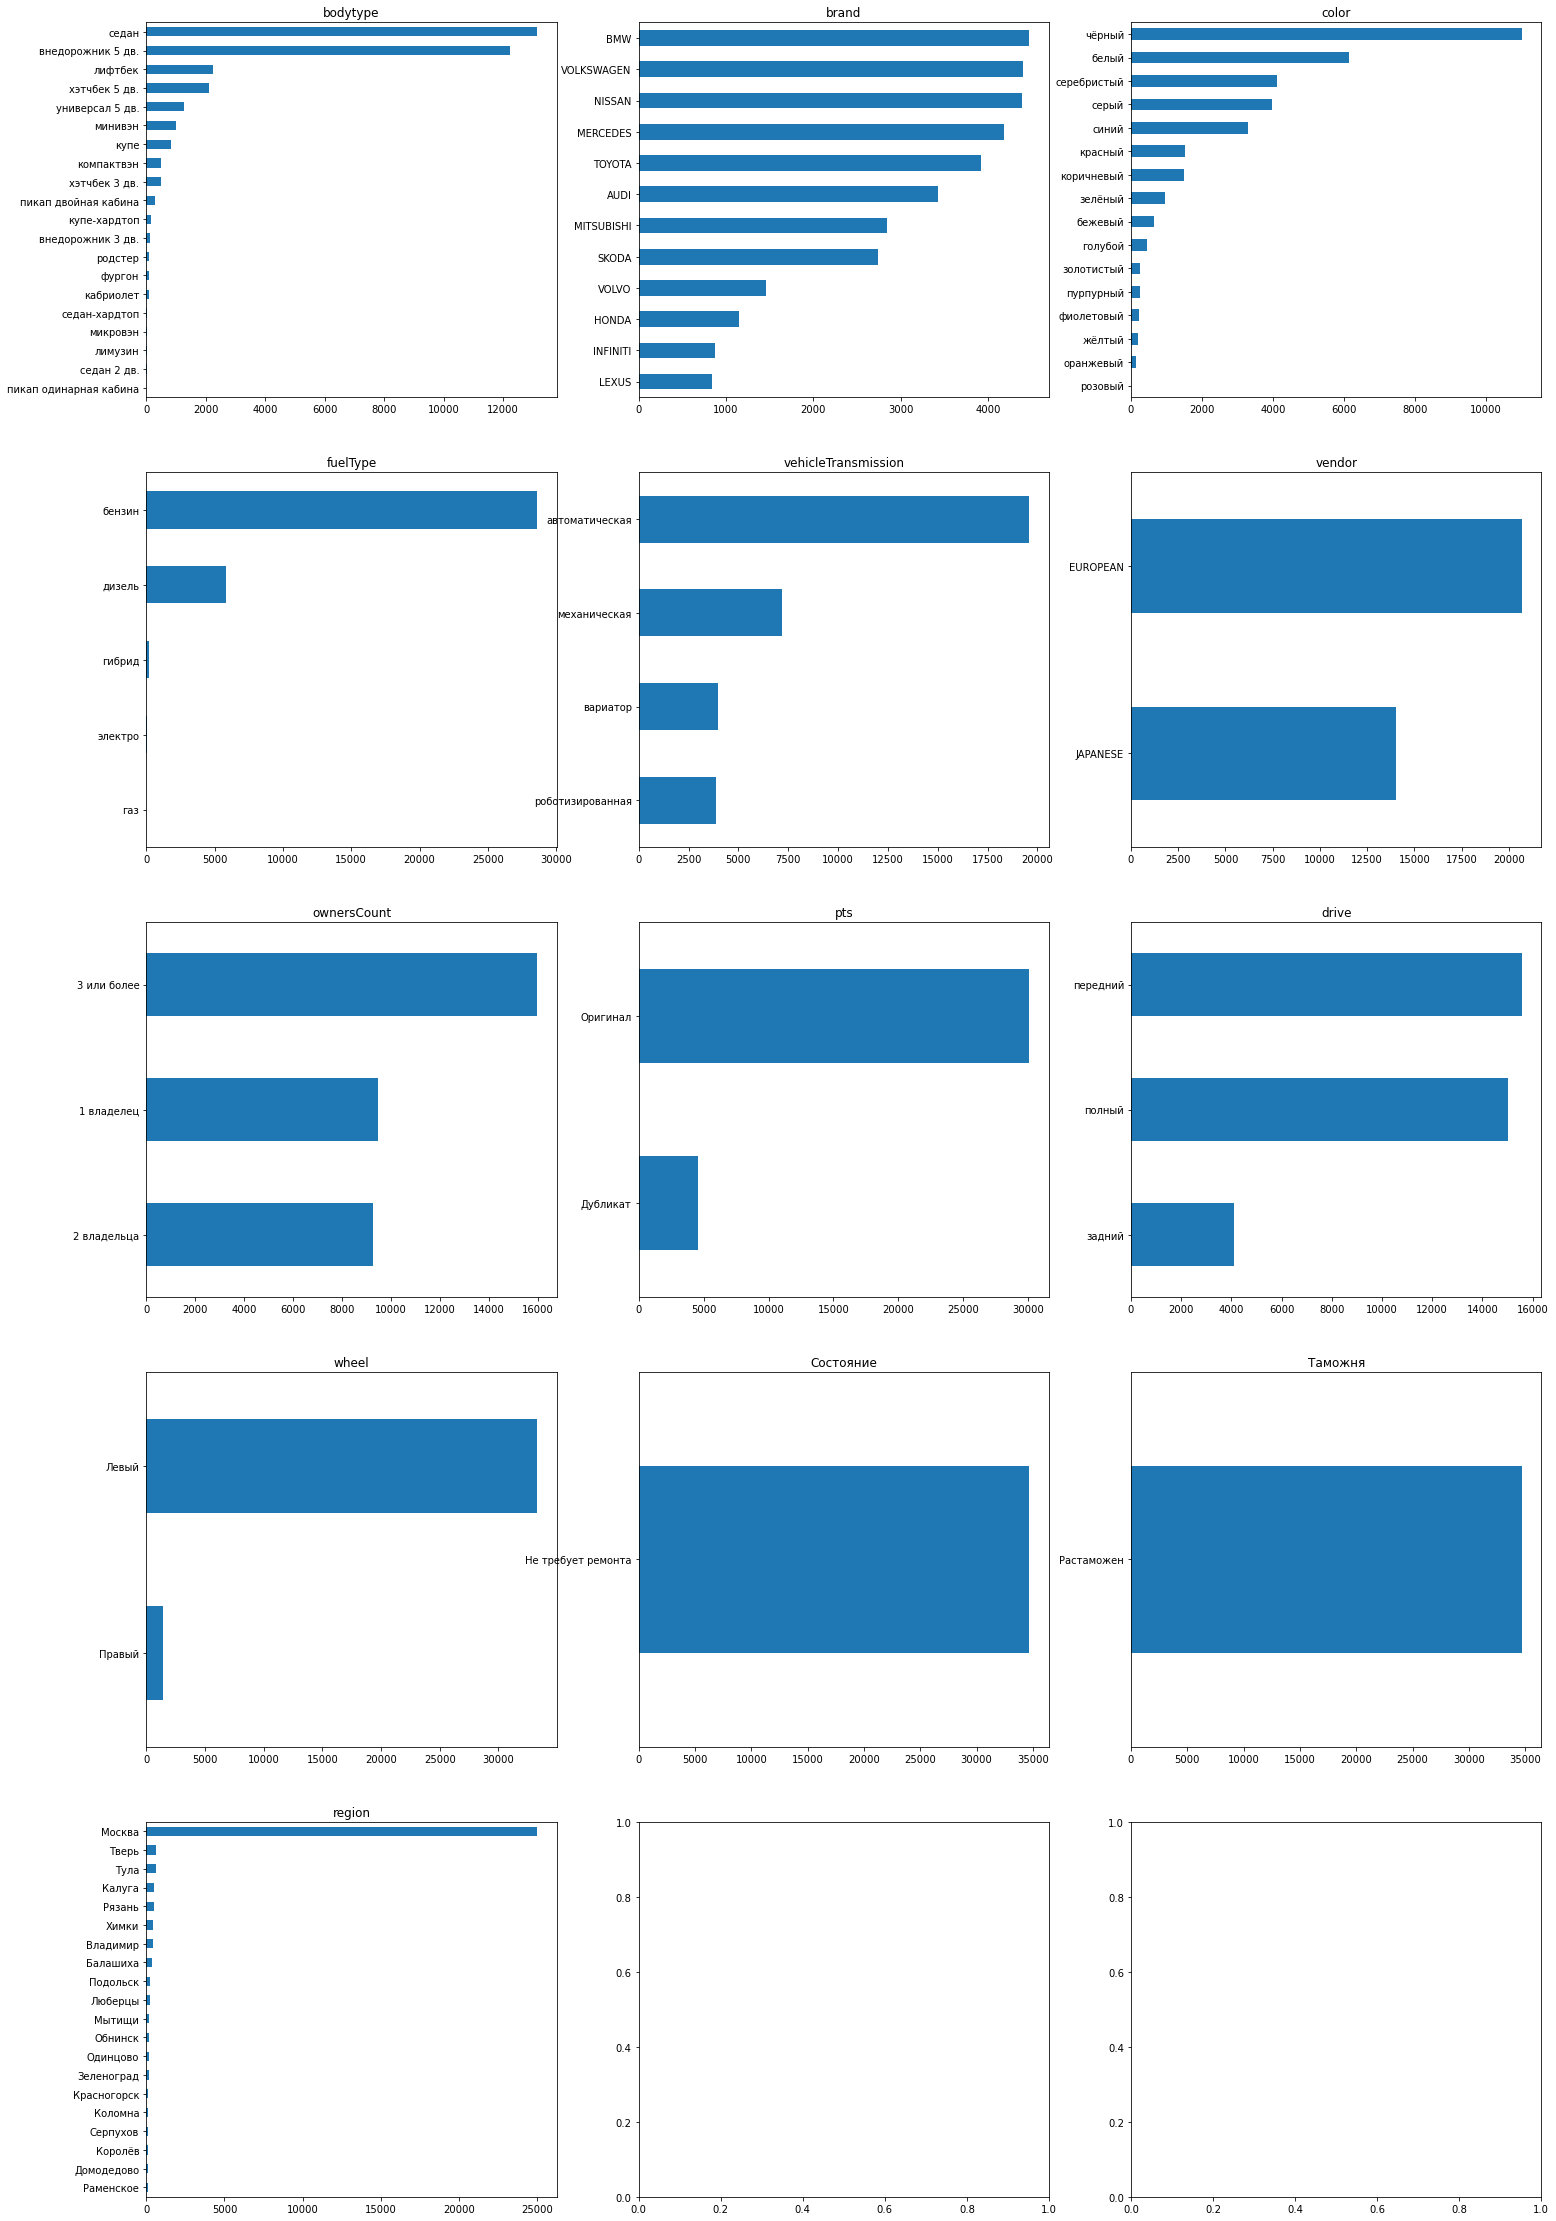

In [10]:
# Анализ распределений основных категориальных признаков определяет характеристики выборки, на которой нужно обучать модель:
# brand: 'SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI','MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'
# vendor: 'EUROPEAN', 'JAPANESE'
# Состояние: Не требует ремонта
# Таможня: Растаможен
# Регион: Московский и соседние регионы
cat_cols = ['bodytype', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'vendor', 'ownersCount', 'pts', 'drive', 'wheel', 'Состояние', 'Таможня', 'region']

n = len(cat_cols)
p = 3
q = int(np.ceil(n / p))

fig, ax = plt.subplots(q,p, figsize = (25, 8*q))
for i in range(n):
    test[cat_cols[i]].value_counts().nlargest(20).sort_values(ascending = True).plot(kind = 'barh', ax = ax[i // p, i % p], title = cat_cols[i])

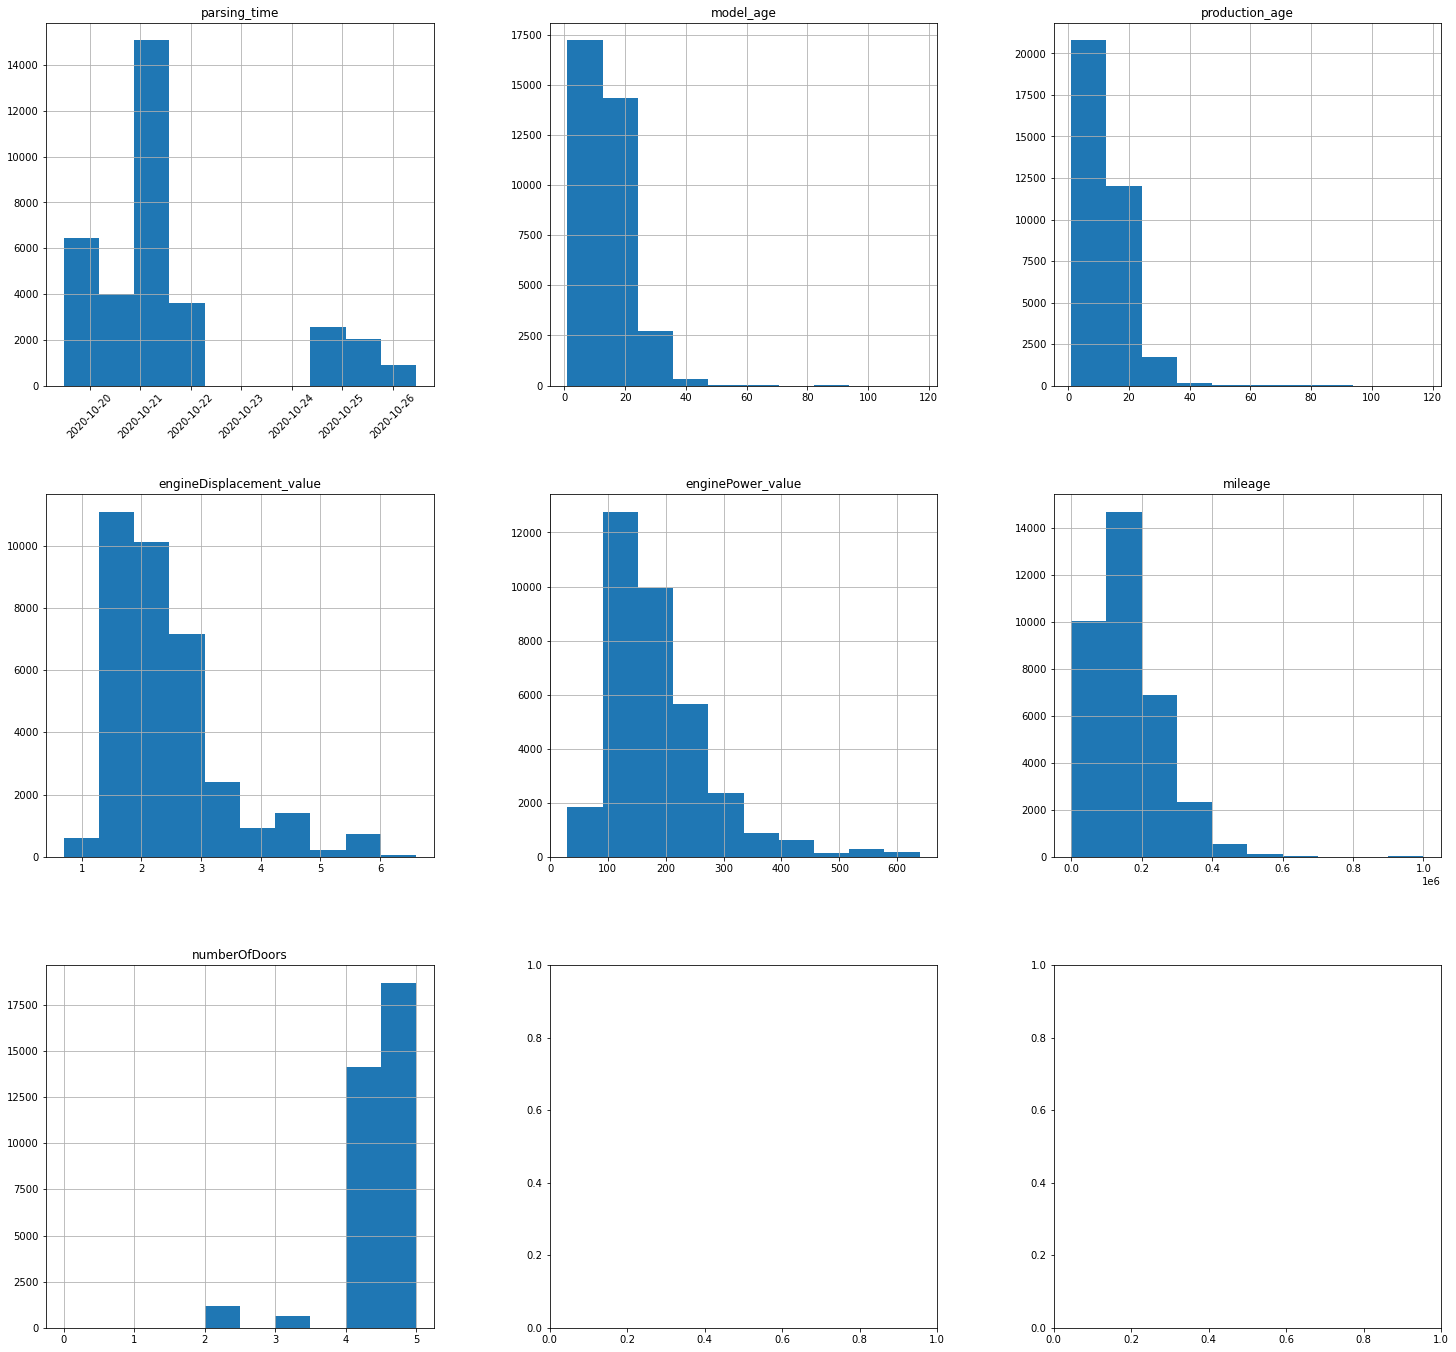

In [11]:
# Анализ распределений основных численных признаков
# Модель нужно обучать на автомобилях с пробегом
num_cols = ['parsing_time', 'model_age', 'production_age', 'engineDisplacement_value', 'enginePower_value', 'mileage', 'numberOfDoors']

n = len(num_cols)
p = 3
q = int(np.ceil(n / p))

fig, ax = plt.subplots(q,p, figsize = (25, 8*q))
for i in range(n):
    if num_cols[i] == 'parsing_time':
        xrot = 45
    else:
        xrot = 0
    test[[num_cols[i]]].hist(xrot = xrot, ax = ax[i // p, i % p])

# Auto.ru parsing

In [12]:
def parse_car(url):
    '''Сбор информации по одному объявлению'''
    soup = BeautifulSoup(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content, 'html.parser')
    try:
        sale = eval(soup.find('div', attrs = {'data-bem': True}).get('data-bem'))['sale-data-attributes']
        brand = sale['mark']
        model_name = sale['modelName']
        mileage = sale['km-age']
        enginePower_value = sale['power']
        if 'price' in set(sale.keys()):
            price = sale['price']
        else:
            price = np.nan

        script = eval(soup.find('script', {'type': 'application/ld+json'}).contents[0])
        bodytype = script['bodyType']
        color = script['color']
        description = script['description']
        fuelType = script['fuelType']
        numberOfDoors = script['numberOfDoors']
        transmission = script['vehicleTransmission']
        productionDate = script['productionDate']
        modelDate = script['modelDate']
        engineDisplacement = script['vehicleEngine']['engineDisplacement']

        try:
            script_init = json.loads(soup.find('script', {'id': 'initial-state'}).contents[0])
            acceleration = script_init['card']['vehicle_info']['tech_param']['acceleration']
            clearance_min = script_init['card']['vehicle_info']['tech_param']['clearance_min']
        except:
            acceleration, clearance_min = np.nan, np.nan

        cardinfo = soup.find('ul', {'class': 'CardInfo'})
        if cardinfo:
            drive = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_drive'}).find_all('span')[1].text
            wheel = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_wheel'}).find_all('span')[1].text
            ownersCount = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_ownersCount'}).find_all('span')[1].text
            pts = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_pts'}).find_all('span')[1].text
            customs = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_customs'}).find_all('span')[1].text
            state = cardinfo.find('li', {'class': 'CardInfoRow CardInfoRow_state'}).find_all('span')[1].text
        else:
            drive, wheel, ownersCount, pts = '', '', '', ''
    except:
        print(url) # Случаи ошибки загрузки страницы или ошибочного содержания редки
        return None

    return pd.DataFrame([(url, price, brand, model_name, modelDate, productionDate,
                          mileage, bodytype, color, numberOfDoors,
                          fuelType, enginePower_value, engineDisplacement, transmission, acceleration, clearance_min,
                          drive, wheel, ownersCount, pts, customs, state, description)], 
                        columns = ['url', 'price', 'brand', 'model_name', 'modelDate', 'productionDate',
                          'mileage', 'bodytype', 'color', 'numberOfDoors',
                          'fuelType', 'enginePower_value', 'engineDisplacement', 'transmission', 'acceleration', 'clearance_min',
                          'drive', 'wheel', 'ownersCount', 'pts', 'customs', 'state', 'description'])

In [13]:
def parse_all_pages(brand):
    '''Сбор ифнормации со всех объевлений брэнда с пробегом
    auto.ru позволяет просматривать не более 99 страниц объявлений, поэтому собираем в цикле по году производства
    '''
    start_time = time.time()
    links = []
    for year in tqdm(range(1950, 2022)):
        url = 'https://auto.ru/cars/' + brand + '/' + str(year) + '-year/used/'
        soup = BeautifulSoup(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content, 'html.parser')  
        count = soup.find('span', {'class': 'ButtonWithLoader__content'})
        if count:
            count = int(re.sub('[^0-9]','',soup.find('span', {'class': 'ButtonWithLoader__content'}).text))
            print(brand, year, count)
        else:
            count = 0
        i, length, skip = 1, 0, 0
        while (length < count) & (i <= 99):
            portion = BeautifulSoup(requests.get(url + '?page=' + str(i), headers={'User-Agent': 'Mozilla/5.0'}).content, 'html.parser').find_all('a', {'class': 'Link ListingItemTitle-module__link'})
            portion = [x.get('href') for x in portion]
            inc = len(portion)
            if inc == 0:
                print(url + '?page=' + str(i))
                skip += 1
            if skip == 10:
                break
            if links:
                links += portion
            else:
                links = portion
            length += inc
            i += 1

    result = []
    for link in tqdm(links):
        row = parse_car(link)
        if row is not None:
            result.append(row)
    result = pd.concat(result).reset_index().drop(columns = ['index']).drop_duplicates()
    result.to_csv(brand + '-' + datetime.today().strftime('%Y-%m-%d') + '.csv', index = False)
    print('Total time (min):', np.round((time.time() - start_time)/60, 2))
    return result

# Загрузка на примере редкого бренда
#cars = parse_all_pages('lamborghini')

In [14]:
# Загружаем объявления по брендам из тестового сэмпла. 
# Ввиду ограничений kaggle на время сессии и срока хранения файлов загрузка производилась с локального компьютера в течение суток
brand_list = ['skoda', 'audi', 'honda', 'volvo', 'bmw', 'nissan', 'infiniti', 'mercedes', 
              'toyota', 'lexus', 'volkswagen', 'mitsubishi']
#for brand in brand_list:
#    parse_all_pages(brand)

In [15]:
# Загружаем результат парсинга из csv-файлов
cars = []
for dirname, _, filenames in os.walk('/kaggle/input/autoru-20210328'):
    for filename in filenames:
        if 'extra' not in filename:
            cars.append(pd.read_csv(os.path.join(dirname, filename)))
cars = pd.concat(cars).reset_index().drop(columns = ['index'])
cars = cars[(cars['price'].isnull() == False) & (cars['mileage'] > 0)]

In [16]:
# Загружаем дополнительные поля из csv
cars_extra = []
for dirname, _, filenames in os.walk('/kaggle/input/autoru-20210328'):
    for filename in filenames:
        if 'cars_extra' in filename:
            cars_extra.append(pd.read_csv(os.path.join(dirname, filename)))
cars_extra = pd.concat(cars_extra).reset_index(drop=True)
cars_extra = cars_extra[cars_extra.columns[1:]]

In [17]:
# Раскладываем бинарные признаки по столбцам. Для сокращения времени обновления грузим из csv-файла
if False:
    cars_extract = cols_extra(cars_extra, len(cars_extra))
cars_extract = pd.read_csv('/kaggle/input/autoru-20210328/cars_extract.csv')

In [18]:
# Оставляем только объявления о продаже моделей, аналогичных test
cars = cars.merge(cars_extract, how = 'left', left_on = 'url', right_on = 'url').fillna(0)
cars = cars[cars['code'].isin(set(test['code']))]
#cars = cars[cars['region'].isin(set(test['region']))]

# Modeling

In [19]:
cars.shape

(122123, 239)

In [ ]:
cars = cars.fillna(0)
cars['engineDisplacement_value'] = cars['engineDisplacement'].apply(lambda x: float(x.split(' ')[0]) if x.strip() != 'LTR' else -1.0)
cars['model_age'] = 2021 - cars['modelDate']
cars['production_age'] = 2021 - cars['productionDate']
cars['model_maturity'] = cars['productionDate'] - cars['modelDate']
cars['mileage_annual'] = cars['mileage'] / np.maximum(cars['production_age'],1)
cars['price_log'] = np.log(cars['price'])

In [20]:
cars['brand'].value_counts()

TOYOTA        22560
NISSAN        17201
VOLKSWAGEN    16601
MERCEDES      14234
BMW           12909
MITSUBISHI     9189
AUDI           8946
SKODA          7481
HONDA          5413
LEXUS          3263
VOLVO          2656
INFINITI       1670
Name: brand, dtype: int64

In [92]:
def get_words(s):
    '''Перевод комментария в список слов'''
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 'ок', 'кстати', 'который', 'мочь', 'весь', 'еще', 'также', 'свой','ещё', 'ул', ''])
    words = re.sub('[^ёйцукенгшщзхъэждлорпавыфячсмитьбю ]', ' ', s.lower()).split(' ')
    return [x for x in words if (x not in stop_words) & ('авто' not in x)]

In [95]:
cars['desc_list'] = cars['description'].apply(lambda x: get_words(x))

<AxesSubplot:>

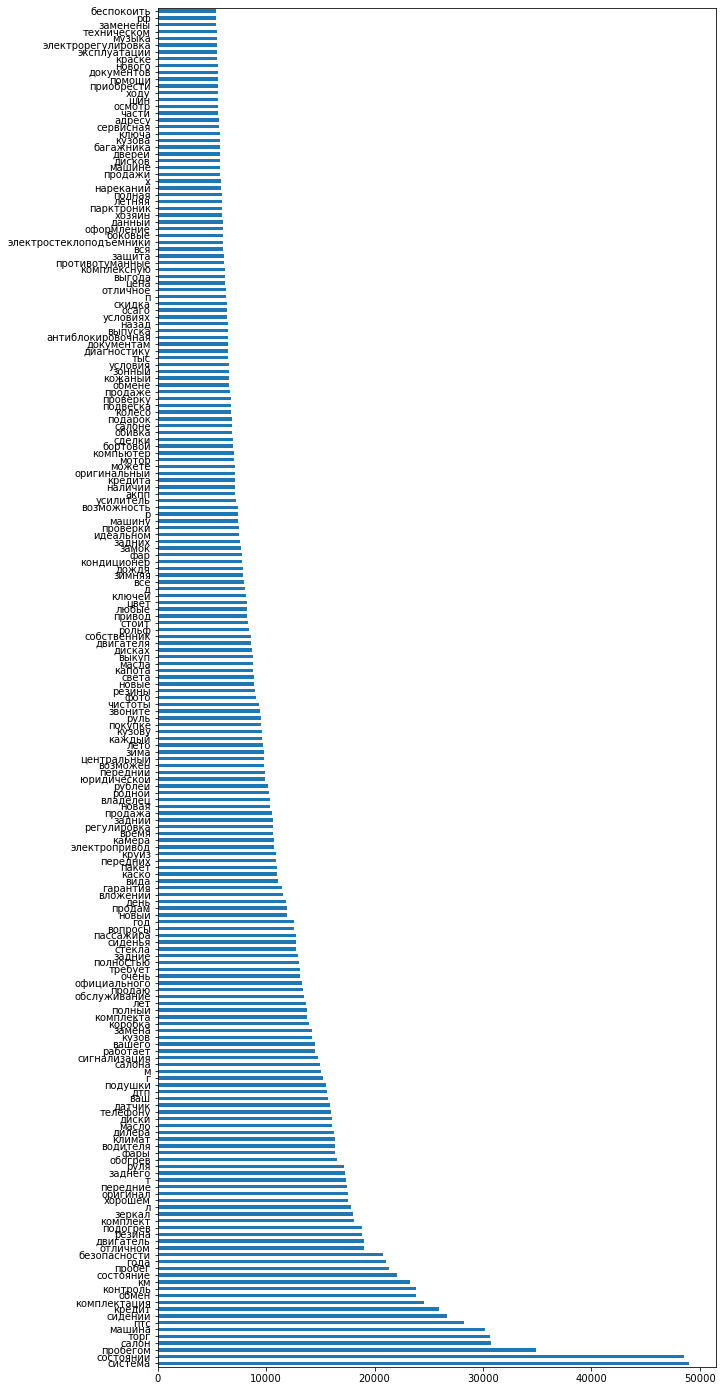

In [110]:
# Выделение наиболее высокочастотных слов
res = []
for words in cars['desc_list']:
    res += words
c = collections.Counter()
for word in res:
    c[word] += 1
freq_words = pd.Series(c).nlargest(200)
freq_words.plot(kind = 'barh', figsize = (10,25))

In [111]:
for word in freq_words.index:
    cars[word] = cars['desc_list'].apply(lambda x: 1 if word in set(x) else 0)

In [112]:
# Сохраняем только значимые слова
wrds = cars[['price_log']+list(freq_words.index)].corr()['price_log'].sort_values(ascending = False)
wrds = list(wrds[(np.abs(wrds) > 0.2) & (wrds < 1)].index)
wrds

['дилера',
 'комплектация',
 'официального',
 'система',
 'пробегом',
 'сидений',
 'контроль',
 'кредит',
 'пакет',
 'света',
 'обслуживание',
 'фары',
 'салона',
 'круиз',
 'ваш',
 'камера',
 'гарантия',
 'дождя',
 'ходу']

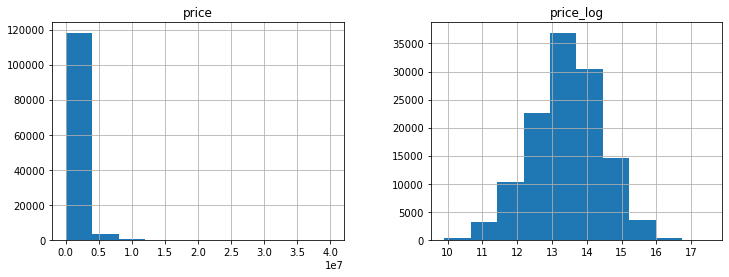

In [25]:
# Рапсределение цены имеет длинный хвост. Правильнее будет моделировать ее логарифм, имеющий близкое к нормальному распределение
fig, ax = plt.subplots(1,2, figsize = (12,4))
cars[['price']].hist(ax = ax[0])
cars[['price_log']].hist(ax = ax[1]);

In [26]:
# Выделяем значимые факторы комплектации
eq = cars[['price_log']+list(cars_extract.columns[5:])].corr()['price_log']
eq = list(eq[(eq > 0.3) & (eq < 1)].index)

XGBoost train MAPE:  9.11173
XGBoost test MAPE:  13.8293
Execution time: 66.0


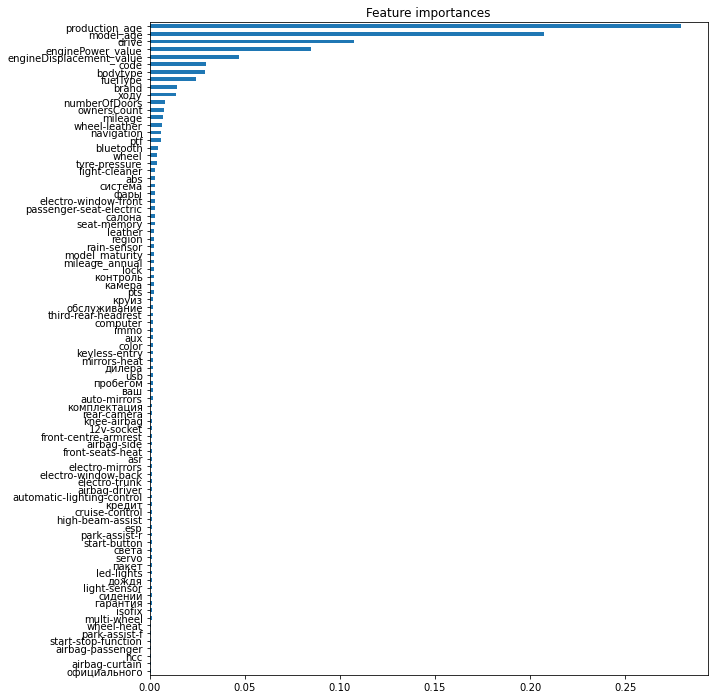

In [113]:
start_time = time.time()
def mape(X, y, model):
    return np.round(mean_absolute_percentage_error(y, model.predict(X))*100,5)

def mape_exp(X, y, model):
    return np.round(mean_absolute_percentage_error(y, np.exp(model.predict(X)))*100,5)

def col_mean(tr, tst, col, target):
    '''Заменяем номинальные признаки на среднюю цену при частотах свыше порога
    Низкочастотные относим в отдельную группу'''
    rep = dict(tr.groupby(col)[target].agg(['count','mean']).query('count >= 50')['mean'])
    target_mean = tr[~tr[col].isin(list(rep.keys()))][target].mean()
    tr[col] = tr[col].map(rep).fillna(target_mean)
    tst[col] = tst[col].map(rep).fillna(target_mean)

target = 'price_log'    
train, valid = train_test_split(cars, test_size = 0.3)
#'model_name',
cat_cols = ['brand','code','region','bodytype','color','fuelType','drive','wheel','ownersCount','pts']#, 'price_segment']#,'transmission'
for col in cat_cols:
    col_mean(train, valid, col, target)

factors = ['model_age','production_age','engineDisplacement_value','model_maturity','mileage','mileage_annual','numberOfDoors','enginePower_value'] + cat_cols + eq + wrds

#,'clearance_min','acceleration'
#params_boost = {'max_depth':10, 'n_estimators':200, 'learning_rate':0.1}
params_xgbr = {'verbosity':0, 'n_estimators':500, 'max_depth':6}

#boost = GradientBoostingRegressor(**params_boost).fit(train[factors], train[target])
xgbr = xgb.XGBRegressor(**params_xgbr).fit(train[factors], train[target])
pd.Series(xgbr.feature_importances_, index = factors).sort_values().plot(kind = 'barh', title = 'Feature importances', figsize = (10,12))
print('XGBoost train MAPE: ', mape_exp(train[factors], train['price'], xgbr))
print('XGBoost test MAPE: ', mape_exp(valid[factors], valid['price'], xgbr))
print('Execution time:', np.round(time.time() - start_time))

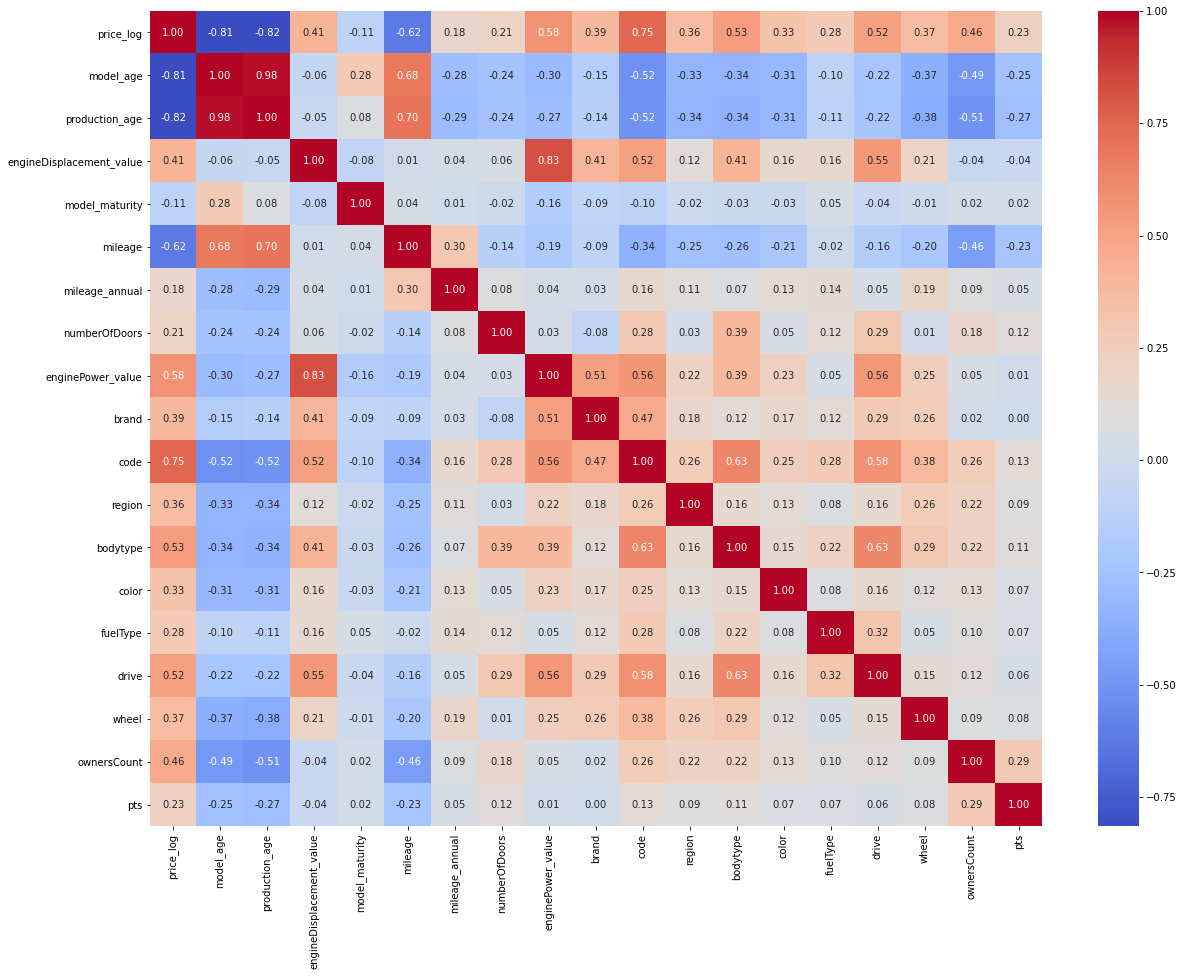

In [28]:
# Несмотря на корреляцию 0.98 между model_age и production_age, исключение любого из признаков приводит к снижению качества модели на тестовой выборке
fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(train[[target] + ['model_age','production_age','engineDisplacement_value','model_maturity','mileage','mileage_annual','numberOfDoors','enginePower_value'] \
                  + cat_cols].corr(), annot = True, cmap = 'coolwarm', fmt = '.2f');

# Submission

In [29]:
set(factors) - set(test.columns)

set()

In [114]:
test['desc_list'] = test['description'].apply(lambda x: get_words(x))

In [115]:
for word in wrds:
    test[word] = test['desc_list'].apply(lambda x: 1 if word in set(x) else 0)

XGBoost train MAPE:  9.85894
Execution time: 91.0


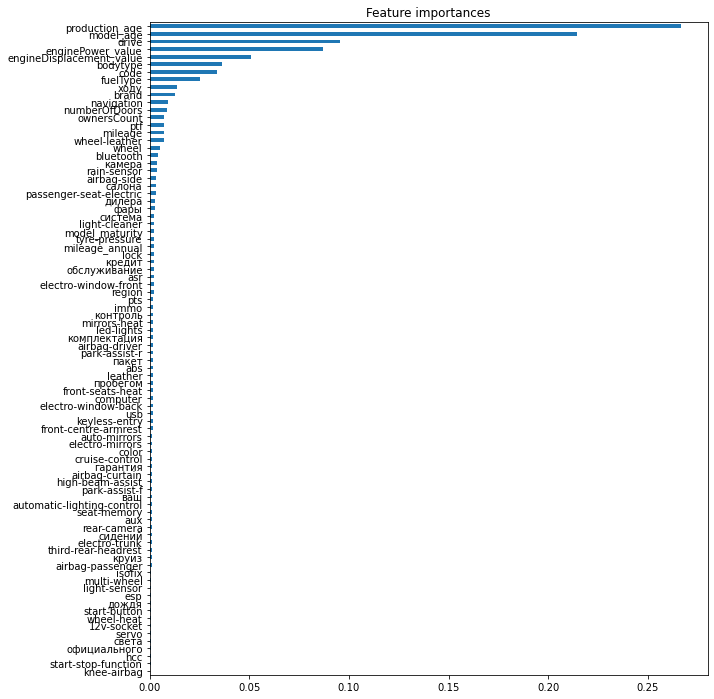

In [116]:
# Основной вклад в прогноз дает давность производства, Возраст модели сильно коррелирует с давностью производства, поэтому их вклад нужно рассматривать в совокупности
# Далее идут характеристики двигателя и привод. Прочие параметры дают незначительный вклад
start_time = time.time()
train = cars.copy()
test_copy = test.copy().fillna(0)
for col in cat_cols:
    col_mean(train, test_copy, col, target)

xgbr = xgb.XGBRegressor(**params_xgbr).fit(train[factors], train[target])
pd.Series(xgbr.feature_importances_, index = factors).sort_values().plot(kind = 'barh', title = 'Feature importances', figsize = (10,12))
print('XGBoost train MAPE: ', mape_exp(train[factors], train['price'], xgbr))
print('Execution time:', np.round(time.time() - start_time))

In [117]:
pd.read_csv('/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv')

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0
...,...,...
34681,1101369263,0
34682,1101369581,0
34683,1101364889,0
34684,1101362518,0


In [118]:
test_copy[factors].isnull().sum()

model_age                   0
production_age              0
engineDisplacement_value    0
model_maturity              0
mileage                     0
                           ..
ваш                         0
камера                      0
гарантия                    0
дождя                       0
ходу                        0
Length: 86, dtype: int64

In [119]:
# Корректируем прогноз на уровень инфляции. Значение корректировки определяется экспертно. Вообще говоря инфляция неоднородна по возрастам авто и моделям
# Корректировка дает огромный вклад в уточнение прогноза (~0.03 MAPE). 
# По сути чем меньше времени прошло между сбором тестовой выборки и выборки для обучения (в моем случае 5 мес.), тем точнее можно построить модель
# Статья по динамике цен на авто: https://www.autostat.ru/news/47856/
test_copy['price'] = np.exp(xgbr.predict(test_copy[factors])) * 0.9
test_copy[['sell_id','price']].to_csv('submission.csv', index = False)